# Compare salt to volume fluxes between old PanAnt and ACCESS-OM2-01 experiments

In [3]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe
from matplotlib.colors import to_rgba

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41039,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:38011,Total threads: 1
Dashboard: /proxy/40293/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:42927,


In [4]:
# Colours
# Not really necessary but included to be consistent with earlier plots

colors = {'pan01_res': '#0000a2',
          'pan005_res': '#E84141',
          'pan01_pre' : '#18669C',
          'access_pre': 'tab:orange'}

def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

In [5]:
lat_slice = slice(-79,-59)

# Importing data
pathsC_1 = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month.nc'))[24:]
pathsM_1 = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ocean_month.nc'))

pathsC_2 = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean_month.nc'))
pathsM_2 = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean_month.nc'))

In [12]:
# load area
area_old_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
var_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so'].isel(z_l=0,time=0)
area_corr_1 = area_old_1*(var_1*0 +1)

area_old_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt'].isel(st_ocean=0,time=0).sel(yt_ocean=slice(-79,-39))
area_corr_2 = area_old_2*(var_2*0 +1)

In [13]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
depth_shelf_1, shelf_mask_1 = shelf_mask_isobath(depth_1, 'mom6_01')

depth_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask_2 = (0 * depth_2).fillna(1)
depth_shelf_2, shelf_mask_2 = shelf_mask_isobath(depth_2, 'mom5')

## Salt fluxes

Just looking at sea-ice salt fluxes here, because salt fluxes from restoring should be the same. 

In [6]:
def preprocess_1(ds):
    ds = ds[['salt_flux','salt_flux_added']].sel(yh=lat_slice) 
    return ds

cont_pan = xr.open_mfdataset(pathsC_1, preprocess = preprocess_1, chunks = 'auto')
melt_pan = xr.open_mfdataset(pathsM_1, preprocess = preprocess_1, chunks = 'auto')

def preprocess_2(ds):
    ds = ds[['sfc_salt_flux_ice','sfc_salt_flux_restore']].sel(yt_ocean=lat_slice) 
    return ds

cont_acc = xr.open_mfdataset(pathsC_2, preprocess = preprocess_2, chunks = 'auto')
melt_acc = xr.open_mfdataset(pathsM_2, preprocess = preprocess_2, chunks = 'auto')

In [7]:
# Time slice
cont_pan = cont_pan.sel(time=slice('2001-01-01','2010-12-31'))
melt_pan = melt_pan.sel(time=slice('2001-01-01','2010-12-31'))

cont_acc = cont_acc.sel(time=slice('1910-01-01','1919-12-31'))
melt_acc = melt_acc.sel(time=slice('1910-01-01','1919-12-31'))

In [9]:
ice_salt_pan_C = cont_pan['salt_flux'] - cont_pan['salt_flux_added']
ice_salt_pan_M = melt_pan['salt_flux'] - melt_pan['salt_flux_added']

ice_salt_acc_C = cont_acc['sfc_salt_flux_ice']
ice_salt_acc_M = melt_acc['sfc_salt_flux_ice']

In [10]:
ice_salt_pan_anom = ice_salt_pan_M - ice_salt_pan_C
ice_salt_acc_anom = ice_salt_acc_M - ice_salt_acc_C

In [14]:
shelf_ice_pan_C = (area_corr_1 * ice_salt_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
shelf_ice_pan_M = (area_corr_1 * ice_salt_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

shelf_ice_acc_C = (area_corr_2 * ice_salt_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_ice_acc_M = (area_corr_2 * ice_salt_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

In [15]:
shelf_ice_pan_anom = shelf_ice_pan_M - shelf_ice_pan_C
shelf_ice_acc_anom = shelf_ice_acc_M - shelf_ice_acc_C

In [16]:
shelf_ice_pan_C = shelf_ice_pan_C.load()
shelf_ice_pan_M = shelf_ice_pan_M.load()
shelf_ice_acc_C = shelf_ice_acc_C.load()
shelf_ice_acc_M = shelf_ice_acc_M.load()

In [17]:
shelf_ice_pan_anom = shelf_ice_pan_anom.load()
shelf_ice_acc_anom = shelf_ice_acc_anom.load()

In [18]:
shelf_ice_pan_C_new = shelf_ice_pan_C.to_series()['2001-01-16':'2010-12-16']
shelf_ice_pan_M_new = shelf_ice_pan_M.to_series()['2001-01-16':'2010-12-16']
shelf_ice_acc_C_new = shelf_ice_acc_C.to_series()['2001-01-16':'2010-12-16']
shelf_ice_acc_M_new = shelf_ice_acc_M.to_series()['2001-01-16':'2010-12-16']
shelf_ice_pan_anom_new = shelf_ice_pan_anom.to_series()['2001-01-16':'2010-12-16']
shelf_ice_acc_anom_new = shelf_ice_acc_anom.to_series()['1910-01-16':'1919-12-16']

In [19]:
shelf_ice_pan_anom_rm = shelf_ice_pan_anom_new.rolling(window=12, center=True).mean()
shelf_ice_acc_anom_rm = shelf_ice_acc_anom_new.rolling(window=12, center=True).mean()

Text(0, 0.5, 'Salt flux anomaly (kg m$^{-2}$ s$^{-1}$)')

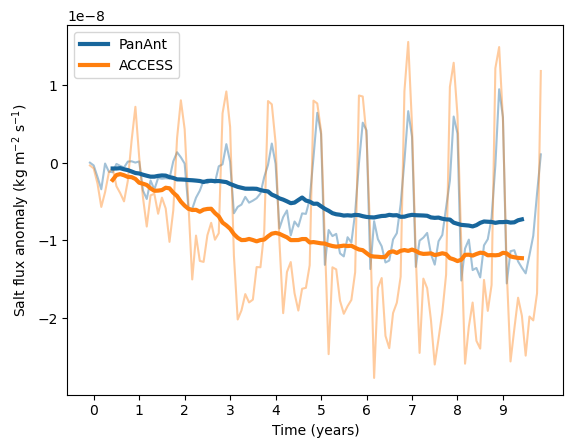

In [32]:
shelf_ice_pan_anom_new.plot(alpha = 0.4, color = colors['pan01_pre'])
shelf_ice_acc_anom_new.plot(alpha = 0.4, color = colors['access_pre'])
shelf_ice_pan_anom_rm.plot(color = colors['pan01_pre'], linewidth=3, label='PanAnt')
shelf_ice_acc_anom_rm.plot(color = colors['access_pre'], linewidth =3, label='ACCESS')

plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)]) # Set x-axis ticks to represent years 1 through 10

plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('Salt flux anomaly (kg m$^{-2}$ s$^{-1}$)')

## Volume fluxes

In [21]:
def preprocess_V_1(ds):
    ds = ds[['wfo','lrunoff']].sel(yh=lat_slice) 
    return ds

cont_V_pan = xr.open_mfdataset(pathsC_1, preprocess = preprocess_V_1, chunks = 'auto')
melt_V_pan = xr.open_mfdataset(pathsM_1, preprocess = preprocess_V_1, chunks = 'auto')

def preprocess_V_2(ds):
    ds = ds[['pme_river','wfiform','wfimelt','runoff']].sel(yt_ocean=lat_slice) 
    return ds

cont_V_acc = xr.open_mfdataset(pathsC_2, preprocess = preprocess_V_2, chunks = 'auto')
melt_V_acc = xr.open_mfdataset(pathsM_2, preprocess = preprocess_V_2, chunks = 'auto')

In [22]:
flux_water_pan_C = cont_V_pan['wfo']
flux_water_pan_M = melt_V_pan['wfo']

flux_runoff_pan_C = cont_V_pan['lrunoff']
flux_runoff_pan_M = melt_V_pan['lrunoff']

flux_water_acc_C = cont_V_acc['pme_river']
flux_water_acc_M = melt_V_acc['pme_river']

flux_wfi_ice_acc_C = cont_V_acc['wfiform'] + cont_V_acc['wfimelt']
flux_wfi_ice_acc_M = melt_V_acc['wfiform'] + melt_V_acc['wfimelt']

flux_runoff_acc_C = cont_V_acc['runoff']
flux_runoff_acc_M = melt_V_acc['runoff']

In [23]:
vol_pan_C = flux_water_pan_C + flux_runoff_pan_C
vol_pan_M = flux_water_pan_M + flux_runoff_pan_M
vol_acc_C = flux_water_acc_C + flux_wfi_ice_acc_C + flux_runoff_acc_C
vol_acc_M = flux_water_acc_M + flux_wfi_ice_acc_M + flux_runoff_acc_M

In [24]:
vol_pan_anom = vol_pan_M - vol_pan_C
vol_acc_anom = vol_acc_M - vol_acc_C

In [25]:
shelf_vol_pan_C = (area_corr_1 * vol_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
shelf_vol_pan_M = (area_corr_1 * vol_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

shelf_vol_acc_C = (area_corr_2 * vol_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_vol_acc_M = (area_corr_2 * vol_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

In [26]:
shelf_vol_pan_anom = shelf_vol_pan_M - shelf_vol_pan_C
shelf_vol_acc_anom = shelf_vol_acc_M - shelf_vol_acc_C

In [27]:
shelf_vol_pan_C = shelf_vol_pan_C.load()
shelf_vol_pan_M = shelf_vol_pan_M.load()
shelf_vol_acc_C = shelf_vol_acc_C.load()
shelf_vol_acc_M = shelf_vol_acc_M.load()

In [28]:
shelf_vol_pan_anom = shelf_vol_pan_anom.load()
shelf_vol_acc_anom = shelf_vol_acc_anom.load()

In [29]:
shelf_vol_pan_C_new = shelf_vol_pan_C.to_series()['2001-01-16':'2010-12-16']
shelf_vol_pan_M_new = shelf_vol_pan_M.to_series()['2001-01-16':'2010-12-16']
shelf_vol_acc_C_new = shelf_vol_acc_C.to_series()['2001-01-16':'2010-12-16']
shelf_vol_acc_M_new = shelf_vol_acc_M.to_series()['2001-01-16':'2010-12-16']
shelf_vol_pan_anom_new = shelf_vol_pan_anom.to_series()['2001-01-16':'2010-12-16']
shelf_vol_acc_anom_new = shelf_vol_acc_anom.to_series()['1910-01-16':'1919-12-16']

In [30]:
shelf_vol_pan_anom_rm = shelf_vol_pan_anom_new.rolling(window=12, center=True).mean()
shelf_vol_acc_anom_rm = shelf_vol_acc_anom_new.rolling(window=12, center=True).mean()

Text(0, 0.5, 'FW volume flux anomaly (kg m$^{-2}$ s$^{-1}$)')

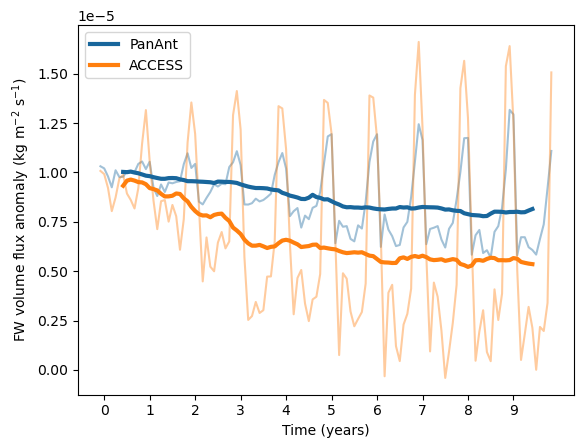

In [33]:
shelf_vol_pan_anom_new.plot(alpha = 0.4, color = colors['pan01_pre'])
shelf_vol_acc_anom_new.plot(alpha = 0.4, color = colors['access_pre'])
shelf_vol_pan_anom_rm.plot(color = colors['pan01_pre'], linewidth=3, label='PanAnt')
shelf_vol_acc_anom_rm.plot(color = colors['access_pre'], linewidth =3, label='ACCESS')

plt.xticks(ticks=range(1, 121, 12), labels=[str(i) for i in range(0, 10)]) # Set x-axis ticks to represent years 1 through 10

plt.legend()
plt.xlabel('Time (years)')
plt.ylabel('FW volume flux anomaly (kg m$^{-2}$ s$^{-1}$)')

### Takeaways

Differences are present in both salt and freshwater volume fluxes.
The scale, and also the scale of the difference, is much greater for the freshwater volume fluxes compared to the salt fluxes.

Given that differences still appear in both salt and freshwater fluxes, I am thinking maybe we can't just look at freshwater volume fluxes only to explain the surface difference. 